In [328]:
import sys
import nltk
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import tensorflow_hub as hub
import tensorflow_text

import warnings
warnings.filterwarnings('ignore')

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jupyter/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jupyter/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

# 1. Carga de Datos y AED

In [2]:
text = pd.read_csv("SMSSpamCollection(Filtrada).csv", on_bad_lines='skip', sep=';')
text.shape

(1290, 2)

In [3]:
text.head()

,resultado,mensaje
0,spam,Free entry in 2 a wkly comp to win FA Cup fina...
1,spam,FreeMsg Hey there darling it's been 3 week's n...
2,ham,As per your request 'Melle Melle (Oru Minnamin...
3,spam,WINNER!! As a valued network customer you have...
4,spam,Had your mobile 11 months or more? U R entitle...


In [ ]:
ratio_spam_and_ham = text["resultado"].value_counts()
ratio_spam_and_ham.plot.pie(autopct = '%1.1f%%', fontsize=10, figsize=(6,6))

In [ ]:
def visualize(label, data):
    words=''
    for msg in data[data['resultado'] == label]['mensaje']:
        msg = msg.lower()
        words+=msg + ''
    wordcloud = WordCloud(width=600, height=400).generate(words)
    plt.figure(figsize=(16,8))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

print("SPAM msj:")
visualize('spam', text)

print("HAM msj:")
visualize('ham', text)

# 2. Preprocesamiento de Texto

## 2.1. Expresiones Regulares

In [4]:
# Use regular expression

def regular_expression(processed) :
    # Replace email addresses with 'email'
    processed = processed.str.replace(r'^.+@[^\.].*\.[a-z]', 'emailaddress', regex=True)

    # Replace URLs with 'webaddress'
    processed = processed.str.replace(r'https?://[A-Za-z0-9./]+', 'webaddress', regex=True)

    # Replace URLs with 'webaddress'
    processed = processed.str.replace(r'www.[A-Za-z0-9./]+', 'webaddress', regex=True)

    # Replace money symbols with 'moneysymb' (£ can by typed with ALT key + 156)
    processed = processed.str.replace(r'£|\$', 'moneysymb', regex=True)

    # Replace 10 digit phone numbers (formats include paranthesis, spaces, no spaces, dashes) with 'phonenumber'
    processed = processed.str.replace(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$', 'phonenumbr', regex=True)

    # Replace numbers with 'numbr'
    processed = processed.str.replace(r'\d+(\.\d+)?', 'numbr', regex=True)
    
    # Remove punctuation
    processed = processed.str.replace(r'[^\w\d\s]', ' ', regex=True)

    # Replace whitespace between terms with a single space
    processed = processed.str.replace(r'\s+', ' ', regex=True)

    # Remove leading and trailing whitespace
    processed = processed.str.replace(r'^\s+|\s+?$', '', regex=True)
    
    return processed

In [5]:
# Apply lowercase

def lowercase(processed) :
    processed = processed.str.lower()
    return processed

## 2.2. Stop Words

In [6]:
# Remove Stop Words

def stop_words(processed) :
    stop_words = set(stopwords.words('english'))
    processed = processed.apply(lambda x: ' '.join(term for term in x.split() if term not in stop_words))
    return processed

## 2.3. Stemming and Lemmatization

Stemming identifies the common root form of a word by removing or replacing word suffixes (e.g. “flooding” is stemmed as “flood”), while lemmatization identifies the inflected forms of a word and returns its base form (e.g. “better” is lemmatized as “good”).

Huang, X., Li, Z., Wang, C., & Ning, H. (2020). Identifying disaster related social media for rapid response: a visual-textual fused CNN architecture. International Journal of Digital Earth, 13(9), 1017–1039. https://doi.org/10.1080/17538947.2019.1633425

In [7]:
# Apply ONLY Stemming

def stemming(processed) :
    snow = nltk.SnowballStemmer(language='english')
    processed = processed.apply(lambda x: ' '.join(snow.stem(term) for term in x.split()))
    return processed

In [8]:
# Apply ONLY Lemmatization

def lemmatization(processed) :
    lmt = nltk.stem.WordNetLemmatizer()
    processed = processed.apply(lambda x: ' '.join(lmt.lemmatize(term) for term in x.split()))
    return processed

## 2.4. Aplicar preprocesamientos

In [9]:
def preprocessing(processed) :
    processed = regular_expression(processed)
    processed = lowercase(processed)
    processed = stop_words(processed)
    # processed = stemming(processed)
    processed = lemmatization(processed)
    return processed

In [16]:
processed = preprocessing(text["mensaje"])

# 3. Definir Modelo de Clasificación

## 3.1. Machine Learning

In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score

import time

In [109]:
def confusion_matrix(clf_best, X_test, y_test) :
    disp = ConfusionMatrixDisplay.from_estimator(
       clf_best,
       X_test,
       y_test,
       display_labels=None,
       cmap=plt.cm.Blues,
       normalize=None)

    disp.ax_.set_xlabel('Predicción');
    disp.ax_.set_ylabel('Realidad'); 
    disp.ax_.xaxis.set_ticklabels(['0', '1']); 
    disp.ax_.yaxis.set_ticklabels(['0', '1']);
    
    print(disp.confusion_matrix)

    plt.show()

In [402]:
def classifier(clf, parameters, X_train, y_train, X_test, y_test) :
    #### Train
    print('=> Train')
    print(' ')
    # Start stopwatch
    tic = time.time() 
    clf = GridSearchCV(clf, parameters, scoring = 'f1', n_jobs = -1)
    clf.fit(X_train, y_train)
    print('Best estimator: ', clf.best_estimator_)
    print(' ')
    print('Best mean validation f1 score: ', clf.cv_results_['mean_test_precision'][clf.best_index_])
    print('Best std validation f1 score: ', clf.cv_results_['std_test_precision'][clf.best_index_])
    print(' ')
    print('Best mean validation precision score: ', clf.cv_results_['mean_test_f1'][clf.best_index_])
    print('Best std validation precision score: ', clf.cv_results_['std_test_f1'][clf.best_index_])
    # End stopwatch train
    toc_train = time.time() 
    print(' ')
    print("time to train process : " + str(round(toc_train - tic, 2)) + " sec" )
    
    #### Test
    print(' ')
    print('=> Test')
    clf_best = clf.best_estimator_
    pred = clf_best.predict(X_test)
    print(' ')
    print('1) Report:')
    print(' ')
    print(classification_report(y_test, pred))
    print(' ')
    print('2) Confussion Matrix')
    print(' ')
    confusion_matrix(clf_best, X_test, y_test)
    print(' ')
    print('3) Cross Val Score (k-fold=5):')
    # End stopwatch train
    toc_test = time.time() 
    print("time to test process : " + str(round(toc_test - toc_train, 2)) + " sec" )
    print(' ')
    # End stopwatch
    toc_test = time.time() 
    print("==== time to total process! : " + str(round(toc_test - tic, 2)) + " sec ====" )

### 3.1.1. Hiperparámetros SVC

In [404]:
from sklearn.svm import SVC
# Hiperparameters
parameters_svc = {
    'C': [0.0001, 0.001, 0.1, 1, 10, 100, 1000], 
    'gamma': np.logspace(-9, 3, 13), 
    'class_weight' : [None, 'balanced'], 
    'kernel': ['rbf', 'linear','sigmoid']
}
# Base model
svc = SVC(random_state=42)

### 3.1.2. Hiperparámetros NuSVC

In [405]:
from sklearn.svm import NuSVC
# Hiperparameters
parameters_nusvc = {
    'nu' : [0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
    'gamma': np.logspace(-9, 3, 13), 
    'class_weight' : [None, 'balanced'], 
    'kernel': ['rbf', 'linear', 'sigmoid']
}
# Base model
nusvc = NuSVC(random_state=42)

## 3.2. Deep Learning

In [370]:
import tensorflow as tf
from tensorflow import keras 
import tensorflow_addons as tfa
    
def deeplearning(X_train, y_train, X_test, y_test, lr, epochs) :
    n = X_train.shape[1]
    y_train = np.array(y_train).reshape(-1,1)
    y_test = np.array(y_test).reshape(-1,1)
    model = keras.models.Sequential([
        keras.layers.Input(shape = (n,), sparse=True),
        keras.layers.Dense(300, activation = 'relu'),
        keras.layers.Dense(100, activation = 'relu'),
        keras.layers.Dense(1, activation = 'sigmoid')
    ])
    model.summary()
    model.compile(optimizer=keras.optimizers.SGD(lr=lr),
                  loss='binary_crossentropy',
                  metrics=[tfa.metrics.F1Score(num_classes=1, threshold=0.5)])
    history = model.fit(X_train, y_train, validation_split=0.3, epochs=epochs, batch_size = 32, verbose = 0)
    # Test
    test_loss, test_acc = model.evaluate(X_test, y_test, steps=5)
    print(' ')
    print('Test score:', test_acc)
    print(' ')
    # Curva de Aprendizaje
    print('Curva de Aprendizaje')
    pd.DataFrame(history.history).astype(float).plot(figsize=(8, 5))
    plt.gca().set_ylim(0, 1)
    plt.show()
    return history

Model: "sequential_123"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_350 (Dense)           (None, 300)               230700    
                                                                 
 dense_351 (Dense)           (None, 100)               30100     
                                                                 
 dense_352 (Dense)           (None, 1)                 101       
                                                                 
Total params: 260,901
Trainable params: 260,901
Non-trainable params: 0
_________________________________________________________________
5/5 [==============================] - 0s 2ms/step - loss: 0.1858 - f1_score: 0.9336
 
Test score: [0.9336493]
 
Curva de Aprendizaje


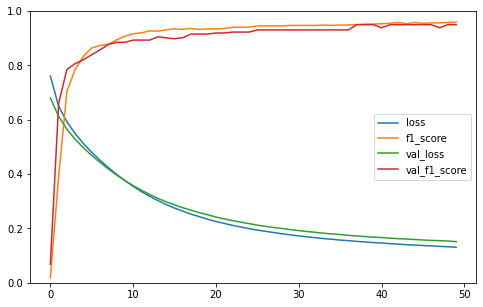

In [371]:
history = deeplearning(X_train_sbert, y_train, X_test_sbert, y_test, 0.0025, 50)

# 4. Definir Métodos de Embedding

## 4.1. Embeding Tradicional

### 4.1.1. TF-IDF

In [98]:
# TfidfVectorizer

from sklearn.feature_extraction.text import TfidfVectorizer

def tfidf(corpus) :
    # Start stopwatch
    tic = time.time()
    
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(corpus).toarray()
    
    # End stopwatch 
    toc = time.time() 
    print("time to embedding process  : " + str(round(toc - tic, 2)) + " sec" )

    return X

### 4.1.2. Hashing Vectorizer

In [350]:
# TfidfVectorizer

from sklearn.feature_extraction.text import HashingVectorizer

def hashingvectorizer(corpus) :
    # Start stopwatch
    tic = time.time()
    
    vectorizer = HashingVectorizer()
    X = vectorizer.fit_transform(corpus).toarray()
    
    # End stopwatch 
    toc = time.time() 
    print("time to embedding process  : " + str(round(toc - tic, 2)) + " sec" )

    return X

## 4.2. Método BERT

Existen varios subgrupos pertenecientes a la familia de modelos BERT, entre ellos:

- BERT Base : modelos con diferentes pesos dadas a conocer por los autores originales de BERT.
- Small BERTS : tienen la misma arquitectura general bloques de transformadores pequeños, lo que le permite explorar soluciones de compromiso entre velocidad, el tamaño y la calidad.
- ALBERT (A Lite BERT) : reduce el tamaño del modelo (pero no el tiempo de cálculo) mediante el intercambio de parámetros entre las capas.
- BERT Expertos : ocho modelos que todos tienen la arquitectura BERT-base, pero ofrecen una elección entre diferentes dominios pre-formación, para alinear más estrechamente con la tarea de destino.
- Electra : tiene la misma arquitectura que el BERT (en tres tamaños diferentes), pero se pre-formó como un discriminador en una puesta a punto que se asemeja a una Red Generativa Antagonica (GAN).
- BERT con hablar-Heads Atención y cerrada GELU [ de base , gran ] tiene dos mejoras en el núcleo de la arquitectura del transformador.

**BERT Base**

Existen 8 difrentes modelos BERT base con diferentes cáracteristicas definidas a continuación según su forma de llamado: 

__/ bert _ (idioma) _ (wwm) _ (case/uncase) _ (#L) _ (#H) _ (#A)__

- (idioma), __en__: Ingles, __zh__: Chino, __multi__: Multilenguaje
- (__wwm__): Si aparece, en el entrenamiento se aplicó un "enmascaramiento de entrada aleatoria" diferente al original propuesto en el paper.
- (uncased/cased): __uncased__: Se normaliza la entrada aplicando _lowercase_, __cased__: Se conserva las mayuscuals/minusculas del texto.
- (#L): Es el número de capas ocultas (es decir, bloques de transformadores).
- (#H): Es el tamaño oculto.
- (#A): Es el número de cabezas de atención.

Los modelos BERT Base son:

- /bert_en_uncased_L-12_H-768_A-12
- /bert_en_uncased_L-24_H-1024_A-16
- /bert_en_wwm_uncased_L-24_H-1024_A-16
- /bert_en_cased_L-12_H-768_A-12
- /bert_en_cased_L-24_H-1024_A-16
- /bert_en_wwm_cased_L-24_H-1024_A-16
- /bert_zh_L-12_H-768_A-12
- /bert_multi_cased_L-12_H-768_A-12

In [320]:
def bert(X, pprcss = 'bert_en_uncased_preprocess/3', enc = 'small_bert/bert_en_uncased_L-8_H-768_A-12/2') :
    # Start stopwatch
    tic = time.time()
    
    # preprocessor: "objeto" que se encargará de transformar el texto en el formato que necesita el modelo BERT para funcionar
    # encoder: "objeto" que será el modelo BERT y se alimentará del resultado de preprocessor, retornando el texto transformado en un vector numérico.
    preprocessor = hub.load("https://tfhub.dev/tensorflow/" + pprcss)
    encoder = hub.load("https://tfhub.dev/tensorflow/" + enc)

    # 5to paso: Vamos a usar el objeto preprocessor, y guardamos su resultado en la variable embedding
    ##   A modo de ejemplo para su revisión, solo vamos a transformar dos textos:
    embedding = preprocessor(X) # texto
    
    # 6to paso: Vamos a codificar el texto con el modelo BERT:
    ##   - Fijarse que el objeto encoder recibe como argumento la variable embedding (resultado de preprocessor)
    ##   - Copiar el siguiente código de forma literal
    pooled_output = encoder(embedding)["pooled_output"]
    
    # 7mo paso: El contenido de la variable pooled_output es una estructura de datos de tipo tensorflow.
    #           Para transformarlo a un dataframe y usarlo de forma tradicional con los modelos clásicos, 
    #           ejecutamos la siguiente linea de código:
    res = pd.DataFrame(pooled_output.numpy())
    
    # End stopwatch 
    toc = time.time() 
    print("time to embedding process  : " + str(round(toc - tic, 2)) + " sec" )
    
    return res

# 5. Train Test

# 6. Resultados

In [19]:
from sklearn.model_selection import train_test_split

X = processed
y = text["resultado"].values
y_transformed = [1 if i == 'ham' else 0 for i in y]

## 6.1. TF-IDF

In [406]:
X_tfidf = tfidf(processed)

time to embedding process  : 0.05 sec


In [407]:
# Test y Train
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_tfidf, y_transformed, test_size=0.3, random_state=42)

### 6.1.1. SVC

In [ ]:
classifier(svc, parameters_svc, X_train_tfidf, y_train, X_test_tfidf, y_test)

=> Train
 


### 6.1.2. NuSVM

In [ ]:
classifier(nusvc, parameters_nusvc, X_train_tfidf, y_train, X_test_tfidf, y_test)

### 6.1.3. Deep Learning

In [363]:
history = deeplearning(X_train_tfidf, y_train, X_test_tfidf, y_test, 0.025, 50)

Model: "sequential_120"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_341 (Dense)           (None, 300)               1221600   
                                                                 
 dense_342 (Dense)           (None, 100)               30100     
                                                                 
 dense_343 (Dense)           (None, 1)                 101       
                                                                 
Total params: 1,251,801
Trainable params: 1,251,801
Non-trainable params: 0
_________________________________________________________________


## 6.2. Hashing Vectorizer

In [352]:
X_hv = hashingvectorizer(processed)
X_hv.shape

time to embedding process  : 0.07 sec


(1290, 1048576)

In [353]:
# Test y Train
X_train_hv, X_test_hv, y_train, y_test = train_test_split(X_hv, y_transformed, test_size=0.3, random_state=42)

### 6.2.1.SVC

In [ ]:
classifier(svc, parameters_svc, X_train_hv, y_train, X_test_hv, y_test)

### 6.2.2. NuSVC

In [ ]:
classifier(nusvc, parameters_nusvc, X_train_hv, y_train, X_test_hv, y_test)

### 6.2.3. Deep Learning

Model: "sequential_117"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_332 (Dense)           (None, 300)               314573100 
                                                                 
 dense_333 (Dense)           (None, 100)               30100     
                                                                 
 dense_334 (Dense)           (None, 1)                 101       
                                                                 
Total params: 314,603,301
Trainable params: 314,603,301
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
20/20 [==============================] - 12s 553ms/step - loss: 0.6930 - f1_score: 0.6128 - val_loss: 0.6926 - val_f1_score: 0.8235
Epoch 2/50
20/20 [==============================] - 9s 454ms/step - loss: 0.6923 - f1_score: 0.8478 - val_loss: 0.6919 - val_f1_score: 0.8479
Epoch 3/50
20/20 

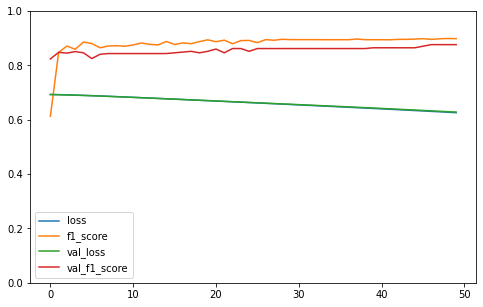

In [355]:
history = deeplearning(X_train_hv, y_train, X_test_hv, y_test, 0.0025, 50)

## 6.3. Small BERT: en uncased L-8 H-768 A-12

In [329]:
X_sbert = bert(text["mensaje"])
X_sbert.shape

time to embedding process  : 86.29 sec


(1290, 768)

In [330]:
# Test y Train
X_train_sbert, X_test_sbert, y_train, y_test = train_test_split(X_sbert, y_transformed, test_size=0.3, random_state=42)

### 6.3.1. SVC

In [ ]:
classifier(svc, parameters_svc, X_train_sbert, y_train, X_test_sbert, y_test)

### 6.3.2. NuSVC

In [ ]:
classifier(nusvc, parameters_nusvc, X_train_sbert, y_train, X_test_sbert, y_test)

### 6.3.3. Deep Learning

Model: "sequential_111"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_314 (Dense)           (None, 300)               230700    
                                                                 
 dense_315 (Dense)           (None, 100)               30100     
                                                                 
 dense_316 (Dense)           (None, 1)                 101       
                                                                 
Total params: 260,901
Trainable params: 260,901
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
20/20 [==============================] - 1s 15ms/step - loss: 0.6975 - f1_score: 0.5937 - val_loss: 0.6499 - val_f1_score: 0.6791
Epoch 2/50
20/20 [==============================] - 0s 6ms/step - loss: 0.6267 - f1_score: 0.7364 - val_loss: 0.5936 - val_f1_score: 0.8030
Epoch 3/50
20/20 [===========

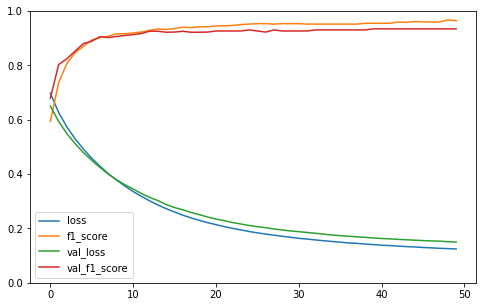

In [341]:
history = deeplearning(X_train_sbert, y_train, X_test_sbert, y_test, 0.0025, 50)

## 6.4. BERT Base: en wwm cased L-24 H-1024 A-16

In [ ]:
X_bert = bert(text["mensaje"], 'bert_en_cased_preprocess/3', 'bert_en_wwm_cased_L-24_H-1024_A-16/4')
X_bert.shape

In [ ]:
# Test y Train
X_train_bert, X_test_bert, y_train, y_test = train_test_split(X_bert, y_transformed, test_size=0.3, random_state=42)

### 6.4.1. SVC

In [ ]:
classifier(svc, parameters_svc, X_train_bert, y_train, X_test_bert, y_test)

### 6.4.2. NuSVC

In [ ]:
classifier(nusvc, parameters_nusvc, X_train_bert, y_train, X_test_bert, y_test)

# 7. Matriz de Contigencia : Resumen Resultados!

## F1-Score

### 1. Validation

|       | TF-IDF | HashingVectorizer | Small Bert | Bert Base |
|-------|--------|-------------------|------------|-----------|
| SVC   | 0.954  | 0.955             | 0.964      | 0.938     |
| NuSVC | 0.948  | 0.956             | 0.962      | 0.962     |

### 2. Testing

## Precission

### 1. Validation

### 2. Testing

## Delay

### Embedding delay

|       |  | 
|-------|--------|
| TF-IDF   | 0.03 sec |
| Hashing Vectorizer | 0.02 sec |
| Small BERT | 68.99 sec |
| BERT Base | 344.05 sec |

### Train delay

|       | TF-IDF    | HashingVectorizer | Small Bert | Bert Base  |
|-------|-----------|-------------------|------------|------------|
| SVC   | 8.92 sec  | 7.05 sec          | 145.34 sec | 251.19 sec |
| NuSVC | 10.32 sec | 8.37 sec          | 186.75 sec | 288.94 sec |